In [ ]:
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

In [1]:
from argparse import Namespace
from pathlib import Path

In [8]:
# path to where the logs live
dataroot = "data/argo2/train/"

# unique log identifier
log_id = "adcf7d18-0510-35b0-a2fa-b4cea13a6d76"
args = Namespace(**{"dataroot": Path(dataroot), "log_id": Path(log_id)})

In [4]:
import argparse
from pathlib import Path
from typing import List

import matplotlib

import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

import av2.geometry.polyline_utils as polyline_utils
import av2.rendering.vector as vector_plotting_utils
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from av2.map.map_api import ArgoverseStaticMap, LaneSegment

In [5]:
# scaled to [0,1] for matplotlib.
PURPLE_RGB = [201, 71, 245]
PURPLE_RGB_MPL = np.array(PURPLE_RGB) / 255

DARK_GRAY_RGB = [40, 39, 38]
DARK_GRAY_RGB_MPL = np.array(DARK_GRAY_RGB) / 255

In [6]:
def single_log_teaser(args: argparse.Namespace) -> None:
    """
    For a single log, render all local crosswalks in green, and pedestrian crossings in purple,
    in a bird's eye view.
    """
    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"
    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=False)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()

    for _, ls in avm.vector_lane_segments.items():
        # right_ln_bnd
        # left_ln_bnd
        vector_plotting_utils.draw_polygon_mpl(ax, ls.polygon_boundary, color="g", linewidth=0.5)
        vector_plotting_utils.plot_polygon_patch_mpl(ls.polygon_boundary, ax, color="g", alpha=0.2)

    # plot all pedestrian crossings
    for _, pc in avm.vector_pedestrian_crossings.items():
        vector_plotting_utils.draw_polygon_mpl(ax, pc.polygon, color="m", linewidth=0.5)
        vector_plotting_utils.plot_polygon_patch_mpl(pc.polygon, ax, color="m", alpha=0.2)

    plt.show()

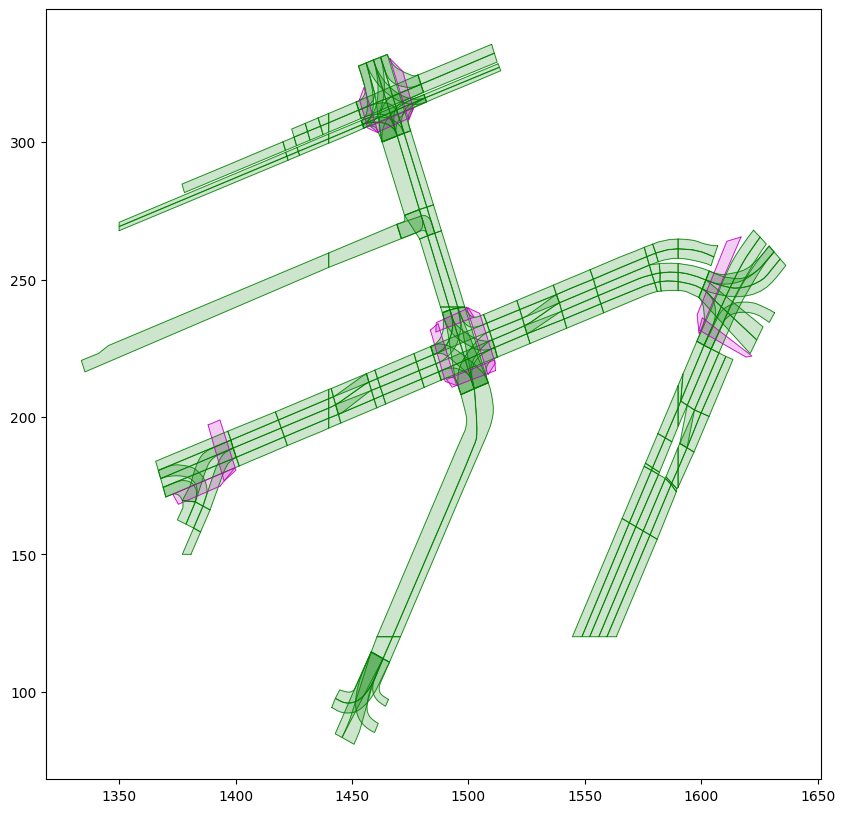

In [10]:
single_log_teaser(args)

In [11]:
def visualize_raster_layers(args: argparse.Namespace) -> None:
    """Visualize the ground surface height/elevation map, w/ a colorbar indicating the value range.

    Also, visualize side-by-side plots of the 3 raster arrays -- ground height, drivable area, ROI.
    """
    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"
    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=True)

    height_array = avm.raster_ground_height_layer.array
    ax = plt.subplot()
    plt.title("Ground surface height (@ 30 centimeter resolution).")
    img = plt.imshow(np.flipud(height_array))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img, cax=cax)
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(np.flipud(height_array))
    plt.title("Ground Surface Height")

    plt.subplot(1, 3, 2)
    da_array = avm.raster_drivable_area_layer.array
    plt.imshow(np.flipud(da_array))
    plt.title("Drivable Area (rasterized \nfrom vector polygons)")

    plt.subplot(1, 3, 3)
    roi_array = avm.raster_roi_layer.array
    plt.imshow(np.flipud(roi_array))
    plt.title("Region of Interest (ROI)")
    plt.show()

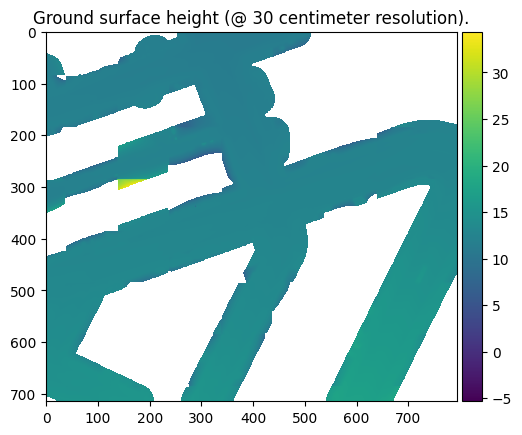

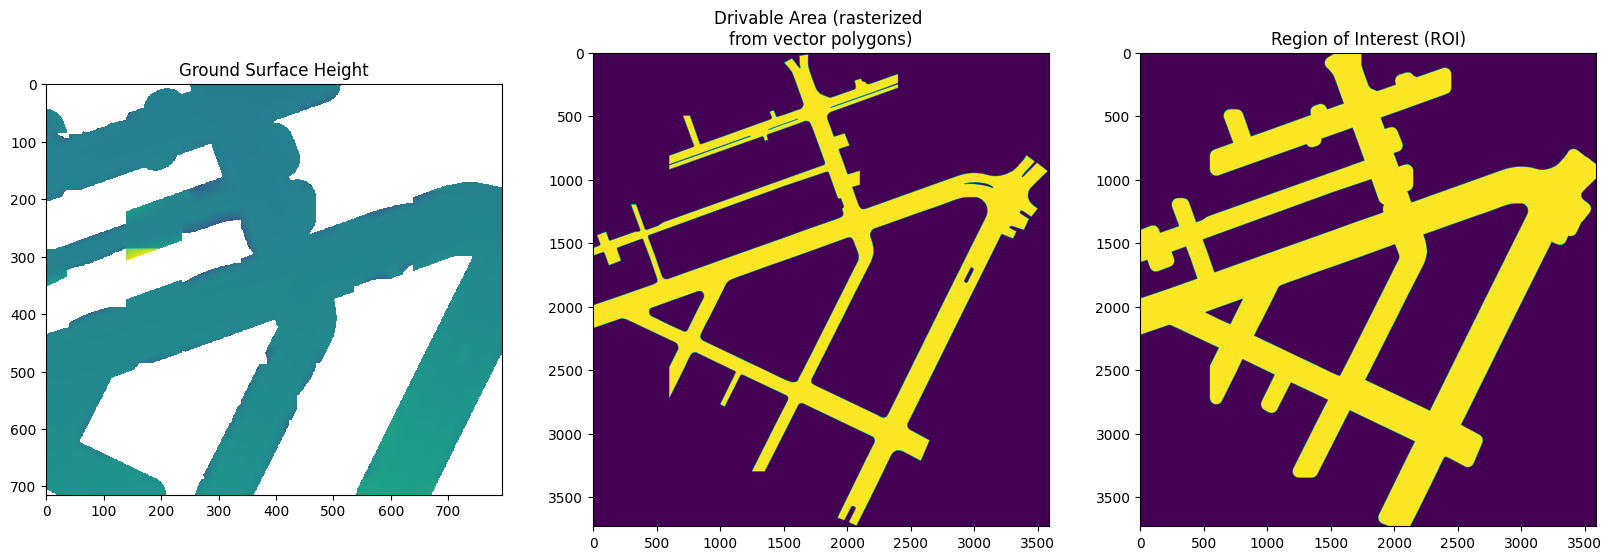

In [12]:
visualize_raster_layers(args)

In [13]:
def plot_lane_segments(
    ax: matplotlib.axes.Axes, lane_segments: List[LaneSegment], lane_color: np.ndarray = DARK_GRAY_RGB_MPL
) -> None:
    """

    Args:
        ax:
        lane_segments:
    """
    for ls in lane_segments:
        pts_city = ls.polygon_boundary
        ALPHA = 1.0  # 0.1
        vector_plotting_utils.plot_polygon_patch_mpl(
            polygon_pts=pts_city, ax=ax, color=lane_color, alpha=ALPHA, zorder=1
        )

        for bound_type, bound_city in zip(
            [ls.left_mark_type, ls.right_mark_type], [ls.left_lane_boundary, ls.right_lane_boundary]
        ):
            if "YELLOW" in bound_type:
                mark_color = "y"
            elif "WHITE" in bound_type:
                mark_color = "w"
            else:
                mark_color = "grey"  # "b" lane_color #

            LOOSELY_DASHED = (0, (5, 10))

            if "DASHED" in bound_type:
                linestyle = LOOSELY_DASHED
            else:
                linestyle = "solid"

            if "DOUBLE" in bound_type:
                left, right = polyline_utils.get_double_polylines(
                    polyline=bound_city.xyz[:, :2], width_scaling_factor=0.1
                )
                ax.plot(left[:, 0], left[:, 1], mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
                ax.plot(right[:, 0], right[:, 1], mark_color, alpha=ALPHA, linestyle=linestyle, zorder=2)
            else:
                ax.plot(
                    bound_city.xyz[:, 0],
                    bound_city.xyz[:, 1],
                    mark_color,
                    alpha=ALPHA,
                    linestyle=linestyle,
                    zorder=2,
                )

In [14]:
def argoverse2_sensor_dataset_teaser(args: argparse.Namespace, save_plot: bool = False) -> None:
    """
    Visualize both ego-vehicle poses and the per-log local vector map.

    Crosswalks are plotted in purple. Lane segments plotted in dark gray. Ego-pose in red.
    """
    loader = AV2SensorDataLoader(data_dir=args.dataroot, labels_dir=args.dataroot)

    fig = plt.figure(1, figsize=(10, 10))
    ax = fig.add_subplot(111)

    log_map_dirpath = Path(args.dataroot) / args.log_id / "map"

    avm = ArgoverseStaticMap.from_map_dir(log_map_dirpath, build_raster=False)

    # retain every pose first.
    traj_ns = loader.get_subsampled_ego_trajectory(args.log_id, sample_rate_hz=1e9)
    # now, sample @ 1 Hz
    traj_1hz = loader.get_subsampled_ego_trajectory(args.log_id, sample_rate_hz=1.0)
    med_x, med_y = np.median(traj_ns, axis=0)

    # Derive plot area from trajectory (with radius defined in infinity norm).
    view_radius_m = 50
    xlims = [med_x - view_radius_m, med_x + view_radius_m]
    ylims = [med_y - view_radius_m, med_y + view_radius_m]

    crosswalk_color = PURPLE_RGB_MPL
    CROSSWALK_ALPHA = 0.6
    for pc in avm.get_scenario_ped_crossings():
        vector_plotting_utils.plot_polygon_patch_mpl(
            polygon_pts=pc.polygon[:, :2],
            ax=ax,
            color=crosswalk_color,
            alpha=CROSSWALK_ALPHA,
            zorder=3,
        )

    plot_lane_segments(ax=ax, lane_segments=avm.get_scenario_lane_segments())

    ax.plot(traj_ns[:, 0], traj_ns[:, 1], color="r", zorder=4, label="Ego-vehicle pose")
    ax.scatter(
        traj_1hz[:, 0], traj_1hz[:, 1], 100, facecolors="none", edgecolors="r", zorder=4
    )  # marker='o', color="r")

    plt.axis("equal")
    plt.xlim(*xlims)
    plt.ylim(*ylims)
    plt.title(f"Log {args.log_id}")
    plt.axis("off")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
argoverse2_sensor_dataset_teaser(args)

KeyboardInterrupt: 